Loading to TensorFlow computation graphs saved in the CostGraphDef format (https://www.tensorflow.org/jvm/api_docs/java/org/tensorflow/proto/framework/CostGraphDef) open-sourced in the DeepMind REGAL paper (https://openreview.net/attachment?id=rkxDoJBYPB&name=original_pdf)

Each node has:
- `input_info` -> Data dependency edges. `preceding_node` gives parent node of edge. `preceeding_port` can be ignored since always set to 1.
- `output_info` -> Data dependency edges. `size` gives size (in Bytes) of data to be sent to child, `alias_input_port` can be ignored since always set to -1.
- `control_input` -> Control dependency edges. Value gives parent node of edge. Can have multiple entries per node.
- `compute_cost` -> Gives estimated time (in ms) to run the operation.

In [1]:
import glob

# get file paths
path_to_files = '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid'
file_paths = glob.glob(path_to_files + '/*')
print(f'Number of files: {len(file_paths)}\nFile paths:')
for path in file_paths:
    print(path)

Number of files: 1000
File paths:
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_1511656116089178154.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_-2261927831951531680.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_-5215600956903632739.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_6504598570401295612.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_-4070510387734494791.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_6604561797351554465.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_2061414314887524887.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_-2024792864167345906.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_-5154055352329412961.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_8486481254233036434.pbtxt
/scratch/datasets/ddl

In [7]:
from collections import defaultdict
import copy
import time
import json

# load a tensorflow computation graph from a .pbtx file
def nodes_from_pbtx(file_path, verbose=False):
    graph, start_time = [], time.time_ns()
    with open(file_path, 'r') as file:
        node_info = None
        for line in file:
            line = line.replace(' ', '').replace('\n', '')
            if line == 'node{':
                # new node entry, save previous node's info and reset
                if node_info is not None:
                    graph.append(copy.deepcopy(node_info))
                node_info = defaultdict(list)  
            elif line == '}':
                # ended previouse element entry
                pass
            elif 'id' in line:
                node_info['id'] = int(line.split(":", 1)[1].strip())
            elif 'name' in line:
                if '_SOURCE' in line:
                    node_info['id'] = 0
            elif 'input_info' in line:
                pass
            elif 'preceding_node' in line:
                node_info['input_info'].append(int(line.split(":", 1)[1].strip()))
            elif 'preceding_port' in line:
                pass
            elif 'output_info' in line:
                pass
            elif 'size' in line:
                node_info['output_info'].append(int(line.split(":", 1)[1].strip()))
            elif 'alias_input_port' in line:
                pass
            elif 'control_input' in line:
                node_info['control_input'].append(int(line.split(":", 1)[1].strip()))
            elif 'compute_cost' in line:
                node_info['compute_cost'] = int(line.split(":", 1)[1].strip())
            else:
                raise Exception(f'Unrecognised line {line}')
    if verbose:
        print(f'Parsed file {file_path} in {(time.time_ns() - start_time)*1e-9:.3f} s')
                
    return graph

file_path = file_paths[0]
nodes = nodes_from_pbtx(file_path, verbose=True)
print(f'Num nodes: {len(nodes)}')
print(json.dumps(nodes, sort_keys=True, indent=2))

Parsed file /scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_1511656116089178154.pbtxt in 0.074 s
Num nodes: 96
[
  {
    "id": 0
  },
  {
    "compute_cost": 65,
    "control_input": [
      0
    ],
    "id": 1,
    "output_info": [
      63
    ]
  },
  {
    "compute_cost": 61,
    "control_input": [
      0
    ],
    "id": 2,
    "output_info": [
      73
    ]
  },
  {
    "compute_cost": 124,
    "id": 3,
    "input_info": [
      2
    ],
    "output_info": [
      54
    ]
  },
  {
    "compute_cost": 51,
    "control_input": [
      0
    ],
    "id": 4,
    "output_info": [
      54
    ]
  },
  {
    "compute_cost": 39,
    "control_input": [
      0
    ],
    "id": 5,
    "output_info": [
      41
    ]
  },
  {
    "compute_cost": 123,
    "id": 6,
    "input_info": [
      3
    ],
    "output_info": [
      49
    ]
  },
  {
    "compute_cost": 243,
    "id": 7,
    "input_info": [
      2,
      3,
      4
    ],
    "output_info": [
      63
    ]

**Side note on below 'hack'**: The .pbtx open-sourced by DeepMind do not say which child each data dependency is connected to, therefore if have e.g. 1 parent node connected to 2 child nodes via 2 data dependencies, then cannot know which data dependency is applied to which child node. Therefore, in below implementation, if there are multiple possible data dependency sizes, we simply randomly sample a size for the dependency from amongst the possible sizes.

In [3]:
import networkx as nx
import random

# construct a networkx graph from loaded nodes
def networkx_from_nodes(nodes):
    graph = nx.DiGraph()
    for node in nodes:
        # add operation
        graph.add_node(node['id'], compute_time=0, output_info=[])
        for attr in node:
            graph.nodes[node['id']][attr] = attr
        
        # add preceding data dependencies
        for parent in node['input_info']:
            # hack: randomly sampling a size if have multiple possibilities (see above markdown cell)
            graph.add_edge(parent, node['id'], size=random.choice(graph.nodes[parent]['output_info']))
                           
        # add preceding control dependencies
        for parent in node['control_input']:
            graph.add_edge(parent, node['id'], size=0)
    
    return graph

computation_graph = networkx_from_nodes(nodes)
print(f'Num nodes: {len(computation_graph.nodes)}')
print(f'Num edges: {len(computation_graph.edges)}')

Num nodes: 96
Num edges: 410


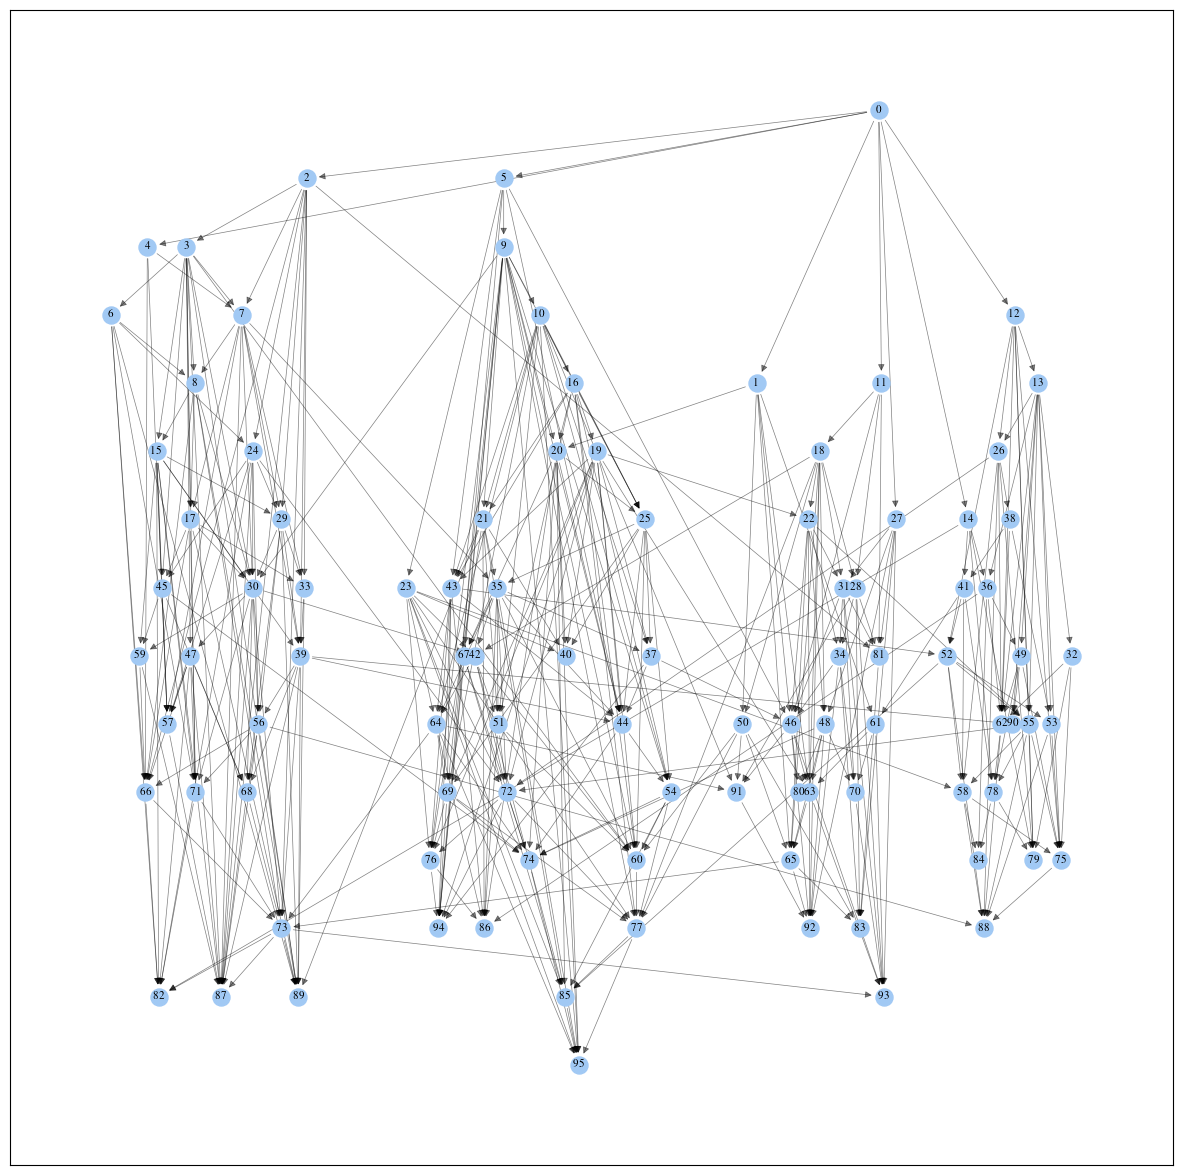

Constructed figure in 6.348 s


In [8]:
from networkx.drawing.nx_pydot import graphviz_layout
import seaborn as sns
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import matplotlib.pyplot as plt

# use latex fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
})

# visualise computation graph
def render_computation_graph(graph,
                             figsize=(15, 15),
                             node_color_palette='pastel',
                             node_size=150,
                             edge_alpha=0.5,
                             edge_width=0.5,
                             font_size=8,
                             verbose=False):
    start_time = time.time_ns()
    fig = plt.figure(figsize=figsize)
    
    pos = graphviz_layout(graph, prog='dot')
    
    node_labels = {node: node for node in graph.nodes}
    nx.draw_networkx_nodes(graph,
                           pos,
                           node_size=node_size,
                           node_color=sns.color_palette(node_color_palette)[0],
                           label=node_labels)
    
    nx.draw_networkx_edges(graph,
                           pos,
                           alpha=edge_alpha,
                           width=edge_width)
    
    nx.draw_networkx_labels(graph, 
                            pos, 
                            labels=node_labels,
                            font_size=font_size)
    
    plt.show()
    
    if verbose:
        print(f'Constructed figure in {(time.time_ns() - start_time) * 1e-9:.3f} s')

render_computation_graph(computation_graph, verbose=True)